In [1]:
# ! pip install numpy
# ! pip install pandas
# ! pip install open-clip-torch
# ! pip install langchain langchain-experimental
# ! pip install langchain_chroma
# ! pip install langchain-ollama
# ! pip install unstructured
# ! pip install openpyxl
# ! pip install langchain-text-splitters

# DO NOT RE-EXECUTE - Creating and Populating the Vector Store

In [1]:
#Create a Vector store and Identify the Embedding Model that it will use
import os, os.path
import shutil
import chromadb
from langchain_experimental.open_clip import OpenCLIPEmbeddings
from langchain_chroma import Chroma
import json
import datetime
from langchain_ollama import OllamaEmbeddings

embed_model_db_path = "./brain_DB_CLIP"
# embed_model_db_path = "./brain_DB_MXBAI"

#Erase Persistent VectorStore Database
if os.path.isfile(embed_model_db_path + "/chroma.sqlite3"):
    # os.remove("./brain_DB/chroma.sqlite3")
    shutil.rmtree(embed_model_db_path)# Delete the entire directory


chroma_client = chromadb.PersistentClient(path= embed_model_db_path)
col_name = 'brain_gen_2_panels'

#Instatiate OpenCLIP model
match embed_model_db_path:
    case "./brain_DB_CLIP":
        emb_func = OpenCLIPEmbeddings(model_name = 'ViT-B-32', checkpoint = 'laion2b_e16') #Multimodal Embedding LLM
    case "./brain_DB_MXBAI":
        emb_func = OllamaEmbeddings(model = 'mxbai-embed-large', temperature = 0) #recommended by Ollama for embedding textual data

#Create the Vector store using Chroma
vectorstore = Chroma(collection_name = col_name,
                     embedding_function = emb_func,
                     client = chroma_client)

collection = chroma_client.get_or_create_collection(name = col_name)

#Check if the collection was created in the Chroma DB Client
def check_collection_exists():
    try:
        collection = chroma_client.get_collection(name = col_name)
        print(f"Collection '{col_name}' exists.")
        return True

    except ValueError:
        print(f"Collection '{col_name}' does not exist.")
        return False

# check_collection_exists()


/Users/elaine/Documents/Projects/ZB_TC_Brain_Generator/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Add SWRS to the Vector Store

In [2]:
#import all of the SWRS after chunking it up.
from langchain_community.document_loaders import UnstructuredExcelLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
import pandas as pd
import re

loader = UnstructuredExcelLoader("./inputs/swrs/SWRS-BrainGENII.xlsx")
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, 
                                               chunk_overlap=100, 
                                               is_separator_regex= True,
                                               separators=[r"\b\d{6,8}\b"], 
                                               add_start_index = True)

# the following text splitters performed worse than the OG:(1000, 200), (500, 200) 
# the following performed the same as the OG: (600, 100)
# text_splitter = RecursiveCharacterTextSplitter(chunk_size=600, 
#                                                chunk_overlap=100, 
#                                                is_separator_regex= True,
#                                                separators=[r"\b\d{6,8}\b"], 
#                                                add_start_index = True)

######################################################
# TODO: Check if Semantic Chunking would work better #
######################################################

chunked_docs = text_splitter.split_documents(docs)

# print(chunked_docs[1])

vectorstore.add_documents(documents = chunked_docs)


['3f3fd603-64b3-43e0-adff-02a472037d72',
 'd80899f4-d8c6-45c0-8bd4-23ee7d4492e3',
 'ef767fb5-ad60-4264-8006-b268a9757320',
 'bfa7fc47-993b-44af-b7d2-f258e0fa4924',
 '99a2423a-d693-4b60-946e-56f6dc95f477',
 '3d991a1f-72d2-48e3-bf6b-a7db8f6ce17e',
 'b9c2c21d-81b1-4210-8bcb-3ec9ac4a4d35',
 '2b7112bf-dbf8-4ae6-a812-32adda9c6780',
 'fd8d785f-f98f-4091-b183-418f15e7f052',
 'ab6c0cc9-5826-4366-9f56-778c64b764ff',
 'fecf5415-38de-4701-9988-c656d40b6ef4',
 'a9c8b89f-e848-48c7-8922-ba8508b428fe',
 '48cb93a5-5897-4ac1-a544-aec2d3b10759',
 'f10d0ff6-b834-4997-8d9e-a640ce785441',
 '7cd4e8ad-0311-4bff-ae43-6f1c9c7ad224',
 '620c4870-e32e-4fbf-a883-53d022d4f533',
 '4c5e25d4-f502-48d8-ba77-9f4a1e5f40a7',
 '6c257a9b-6cae-47ad-81b3-f90e32a09b1f',
 '4ba107a2-c5ca-407f-a884-6b8a2feb9a99',
 '4189dca6-b3d2-4116-9a42-19385d9ce0d7',
 'e5cecdae-fc03-4713-bbc8-0e1bdd033f37',
 '5131c0f7-9620-4976-a76b-166c249a73b2',
 '4b095478-bf68-4b40-950c-9823cd4cd09d',
 'e8245f38-beb7-4b1d-8ded-28181163c014',
 'be0d0169-7634-

## Add the JSON files that contain descriptions of all UI components in each panel

In [3]:
# import all of the json files describing each the components contained in each panel in the application

path_json_folder = './inputs/json'
json_filenames = os.listdir(path_json_folder)

all_json_paths = []
for i in range(len(json_filenames)):
    all_json_paths.append(f'{path_json_folder}/{json_filenames[i]}')


all_json_contents = []
all_json_metadata = []

for path in all_json_paths:
    content = open(path).read().strip()
    all_json_contents.append(content)
    all_json_metadata.append({"source": path})

#Add the json files to the vector store
vectorstore.add_texts(texts = all_json_contents,
                      metadatas = all_json_metadata)

print("----CONTEXT VECTORSTORE CREATED------")

----CONTEXT VECTORSTORE CREATED------


# Reaccess Persistent VectorStore that Already Exists

In [13]:
import os, os.path
import chromadb
from langchain_experimental.open_clip import OpenCLIPEmbeddings
from langchain_chroma import Chroma
import datetime
from langchain_ollama import OllamaEmbeddings

chosen_emb_model = "CLIP"
# chosen_emb_model = "MXBAI"

match chosen_emb_model:
    case "CLIP":
        dir = "./brain_DB_CLIP"
        emb_func = OpenCLIPEmbeddings(model_name = 'ViT-B-32', checkpoint = 'laion2b_e16') #Multimodal Embedding LLM
    case "MXBAI":
        dir = "./brain_DB_MXBAI"
        emb_func = OllamaEmbeddings(model = 'mxbai-embed-large', temperature = 0) #recommended by Ollama for embedding textual data

col_name = 'brain_gen_2_panels'
vectorstore = Chroma(persist_directory = dir, 
                     embedding_function = emb_func,
                     collection_name = col_name)
retriever = vectorstore.as_retriever()


# Nodes Outside of Graph

https://github.com/langchain-ai/langgraph/blob/main/examples/rag/langgraph_self_rag.ipynb?ref=blog.langchain.com 


## Compile list of Models you want to test when Infering Answers

In [14]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_ollama.chat_models import ChatOllama
# Models that fail to run the full graph:
#################################
# model_llava = ChatOllama(model="llava:7b", temperature = 0) 

#Models that successfully run the full graph:
#################################
model_gemma = ChatOllama(model = "gemma3:4b", temperature = 0)
model_llama = ChatOllama(model = 'llama3.1:8b', temperature = 0)
model_granite = ChatOllama(model = 'granite3.2:8b', temperature = 0)


def get_current_model (sel_model):
    match sel_model.model:
        case ('gemma3:4b'):
            return 'gemma3-4b'
        case ('llama3.1:8b'):
            return 'llama3.1-8b'
        case ('granite3.2:8b'):
            return ('granite3.2-8b')
        
sel_model = model_llama
model_name = get_current_model(sel_model)
print(model_name)


#Have a way to separate if data is coming from image source or text source
import base64
from PIL import Image
from io import BytesIO

def decode_base64_image(base64_string):
    """Decode a Base64 string into a PIL.Image.Image object."""
    image_data = base64.b64decode(base64_string)
    return Image.open(BytesIO(image_data))


def is_base64(s):
    """Check if a string is Base64 encoded"""
    try:
        return base64.b64encode(base64.b64decode(s)) == s.encode()
    except Exception:
        return False

def reshape_results(docs):
    images = []
    text = []
    for doc in docs:
        doc = doc.page_content  # Extract Document contents
        if is_base64(doc):
            images.append(
                decode_base64_image(doc)
            )  # base64 encoded str
        else:
            text.append(doc)
    return {"images": images, "texts": text}

llama3.1-8b


## Grader of Retrieved Documents: Create LLM that checks the relevance of the retrieved documents

In [15]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field


# Data model
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )


# LLM with function call
structured_llm_grader = sel_model.with_structured_output(GradeDocuments)

# Prompt
system1 = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""

system2 = """You are an expert evaluator. Given a user query and a retrieved document, your task is to assess whether the document is relevant to the query.
First, return one of the following labels:
- RELEVANT – if the document directly answers or provides significant, useful information related to the query.
- PARTIALLY_RELEVANT – if the document touches on the topic but does not fully address the query or only covers part of it.
- IRRELEVANT – if the document does not answer the query or is off-topic.
If the label is "RELEVANT" OR "PARTIALLY_RELEVANT" then give a score of "yes".
If the label is "IRRELEVANT, then give a score of "no".
"""

system3 = """You are a grader assessing the relevance of a retrieved document to a user question.
If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. 
If the document touches on the topic but does not fully address the question or only covers part of it, grade it as relevant.
If the document contains no relevant information, grade it as irrelevant. 
Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.
"""

ret_system_prompt = system1
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", ret_system_prompt),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader

# Uncomment to troubleshoot if Grader of Retrieved documents works without bugs: 
# question = "agent memory"
# docs = retriever.get_relevant_documents(question)
# doc_txt = docs[1].page_content
# print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

## Test Case Generator

### Preprocessing Golden TC Examples

Examples of your desired output should only be fed as part of your prompt. You can do this by passing these examples as variables to the prompt. 

In [16]:
#import all markdown files that are golden examples of test cases
path_tc_folder = './inputs/example_tcs'
tc_filenames = os.listdir(path_tc_folder)

all_tc_paths = []
for i in range(len(tc_filenames)):
    if (not tc_filenames[i].startswith(".")):
        all_tc_paths.append(f'{path_tc_folder}/{tc_filenames[i]}')

all_tc_contents = []
all_tc_metadata = []

for path in all_tc_paths:
    print(path)
    content = open(path).read().strip()
    all_tc_contents.append(content)
    all_tc_metadata.append({"source": path})

#Add the json files to the vector store
# vectorstore.add_texts(texts = all_tc_contents,
#                       metadatas = all_tc_metadata)

./inputs/example_tcs/TC - MKR002 - Setup Breadcrumb Step - Navigation Buttons Flow - Arm is Home (1+ Pointer .json file).md
./inputs/example_tcs/TC - MKR003 - From Select SN Subpanel to Install Pointer Subpanel (1+ Pointer .json file).md
./inputs/example_tcs/TC - MKR001 - Setup Breadcrumb Step - Navigation Flow - Arm is Home (1+ Pointer .json file).md
./inputs/example_tcs/TC - MKR004 - Install Pointer Subpanel - Change SN button (1+ Pointer .json file).md
./inputs/example_tcs/TC - ICT - Image Acquisition Breadcrumb Step - Forward Flow - Check Content.md
./inputs/example_tcs/TC - ICT - Enter Setup Breadcrumb Step - Forward Flow - Arm is Home (1+ Object .json files).md
./inputs/example_tcs/TC - ICT - Return to Setup Breadcrumb Step - Arm Not Home - Flow up to Select Object SN Subpanel (1+ Object .json file).md
./inputs/example_tcs/TC - MKR005 - From Install Pointer Subpanel to Move to Working - Successful Verification.md


### Generate Prompt Templates

In [17]:
template_ex_TC_from_file = """
<INSTRUCTIONS>
You are a test engineer that generates test cases. 
For each test case, provide a brief description of the test case and the test steps.
Every test step must have an expected result of what should be displayed on the screen.
Do not use personal pronouns in the test case. 
The results of a search of a database of screenshots of the application have been provided to give you more context. 
Use the information in the results to help you generate test cases for the specified features accurately.
Not all information in the results will be useful. 
Write as many test cases as needed to completely verify the test case objectives. 
However, if you find any information that's useful for generating a test case for the feature specified by the user, draw from it in your answer. 
<EXAMPLE> {example1} </EXAMPLE>
<EXAMPLE> {example2} </EXAMPLE>
<EXAMPLE> {example3} </EXAMPLE>
</INSTRUCTIONS>

<FEATURE> {feature} </FEATURE>

<RESULTS> {context} </RESULTS>

ANSWER:
"""


template = template_ex_TC_from_file

def gen_TC_w_ex_from_files(feature, context, model = sel_model):
    global template
    template = template_ex_TC_from_file
    prompt = ChatPromptTemplate.from_template(template)
    chain = prompt | model

    example1 = all_tc_contents[0]
    example2 = all_tc_contents[1]
    example4 = all_tc_contents[3]
    example5 = all_tc_contents[4]
    example6 = all_tc_contents[5]
    example7 = all_tc_contents[6]
    example8 = all_tc_contents[7]
    
    return chain.invoke({"example1": example1, "example2": example2, "example3": example4,
                         "feature": feature, "context": context})

numb_ret = 10
output_path = './outputs/'
def output_TC(feature, retrieved_info, answer, iter):
    global numb_ret
    global ret_system_prompt
    global logtime
    model_name = get_current_model(sel_model)
    # logtime = datetime.datetime.now().strftime("%Y_%m_%d-%H_%M_%S")
    file = open(f'{output_path}{str(logtime)}/AIAgent_{model_name}_{iter}.md', 'w')
    file.write("Date: " + logtime +"\n\n")
    file.write("Retriever settings: retriever" + chosen_emb_model + ", k=" + str(numb_ret) +"\n\n")
    file.write("Model used to infer: " + model_name +"\n\n")
    file.write("Feature: " + feature + "\n\n")
    file.write("Prompt to score the relevance of retrieved documents: " + ret_system_prompt + "\n\n")
    file.write("Prompt to Generate TCs: " + template + "\n\n")
    file.write("================================================\n\n")
    file.write('# FILTERED RETRIEVED INFORMATION FROM VECTOR STORE \n\n')
    for image in retrieved_info["images"]:
        file.write(image + '\n\n')
    for text in retrieved_info["texts"]:
        file.write(text+'\n\n')
    file.write("================================================\n\n")
    file.write("# GENERATED TEST CASES: \n\n")
    file.write(answer)
    file.close()

    

## Test Case Subject Rewriter

In [18]:
from langchain_core.output_parsers import StrOutputParser

# Prompt
system = """You a question re-writer that converts an input question to a better version that is optimized \n 
     for vectorstore retrieval. Look at the input and try to reason about the underlying semantic intent / meaning."""
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

question_rewriter = re_write_prompt | sel_model | StrOutputParser()
#Test the questions rewriter outside of the graph:
# question = "Testing "
# question_rewriter.invoke({"question": question})

## Test Case Hallucinator Checker

In [ ]:
# Prompt
system = """You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved documents.
     Give a binary score 'yes' or 'no' score to indicate whether the document is grounded in / supported by the set of documents
     'No' means that the answer is grounded in / supported by the set of documents."""

hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Set of documents: \n\n {documents} \n\n LLM generation: {generation}"),
    ]
)

hallucination_grader = hallucination_prompt | structured_llm_grader

# Create Graph

## Graph State

In [65]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph.message import add_messages, AnyMessage
from typing import Annotated, TypedDict, List

class State(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        messages: history of all messages passed to the LLM
        question: question
        generation: LLM generation
        documents: list of documents
    """
    messages: Annotated[list[AnyMessage], add_messages]
    question: str
    new_question: str
    generation: str
    documents: List[str]
    new_documents: List[str]
    iter: int

memory = MemorySaver()

## Define Graph Nodes

In [66]:
def print_raw_retrieved_doc(prompt, results, iter):
    global numb_ret
    global chosen_emb_model
    global logtime
    model_name = get_current_model(sel_model)
    # logtime = datetime.datetime.now().strftime("%Y_%m_%d-%H_%M_%S")
    file = open(f'{output_path}{str(logtime)}/AIAgent_{model_name}_rawRetrievedDocs_{iter}.md', 'w')
    file.write("Date: " + logtime +"\n\n")
    file.write("================================================\n\n")
    file.write('# RAW RETRIEVED INFORMATION FROM VECTOR STORE \n\n')
    file.write("Retriever settings: retriever" + chosen_emb_model + ", k=" + str(numb_ret) +"\n\n")
    file.write("Model used to infer: " + model_name +"\n\n")
    file.write("Prompt: " + prompt +"\n\n")
    file.write("================================================\n\n")
    for result in results:
        try: #if a doc
            file.write(result.metadata["source"] + " " + str(result.metadata['start_index']) + "\n\n")
            file.write(result.page_content + "\n\n")
        except: #if an image
            file.write(result.metadata["source"] + "\n\n")
    file.close()

    
        

In [ ]:
def retrieve(state):
    global numb_ret
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    
    iter = state["iter"]

    if iter == 0 or iter == None:
        iter = 1
        question = state["question"]
        documents = retriever.invoke(question, k=numb_ret)
        print_raw_retrieved_doc(question, documents, str(iter))
        return {"question": question, "documents": documents, "iter": iter}
    else:
        iter = state["iter"] + 1
        iter = iter + 1
        new_question = state["new_question"]
        new_documents = retriever.invoke(new_question, k=numb_ret) 
        print_raw_retrieved_doc(new_question, new_documents, str(iter))
        return {"new_question": new_question, "new_documents": new_documents, "iter": iter}


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")

    question = state["question"]
    documents = state["documents"]
    iter = state["iter"]

    if iter > 1:
        new_question = state["new_question"]
        question = question + " and " + new_question
        new_documents = state["new_documents"]

        #Append only unique new documents to the documents List; Exclude any duplicates
        for i in range(len(new_documents)):
            if new_documents[i] not in documents:
                documents.append(new_documents[i])

    # Score each doc
    filtered_docs = []
    for d in documents:
        score = retrieval_grader.invoke({"question": question, "document": d.page_content})
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue

    return {"question": question, "documents": filtered_docs, "new_documents": None}

def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        New key added to state, generation, that contains LLM generation
    """

    print("---TRANSFORM QUERY---")
    question = state["question"]
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}

def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]
    
    processed_docs = reshape_results(documents)

    # RAG generation
    template = template_ex_TC_from_file
    prompt = ChatPromptTemplate.from_template(template)
    chain = prompt | sel_model
    example1 = all_tc_contents[0]
    example2 = all_tc_contents[1]
    example4 = all_tc_contents[3]
    example5 = all_tc_contents[4]
    example6 = all_tc_contents[5]
    example7 = all_tc_contents[6]
    example8 = all_tc_contents[7]
    
    answer = chain.invoke({"example1": example1, "example2": example2, "example3": example5,
                           "feature": question, "context": processed_docs})

    iter = state["iter"]

    output_TC(question, processed_docs, answer.pretty_repr(), str(iter))
    return {"documents": documents, "question": question, "generation": answer}

def hallucination_checker(state):
    """ 
    Given the Generated Test Case, 
    Check that the content is grounded in facts.

    Args: 
        state (dict): The current graph state
    
    Returns:
        state (dict): Updates new_question key with key terms of specs that are missing from test case.
    """
    print("---EVALUATING TEST CASE CONTENT FOR HALLUCINATIONS---")
    documents = state["documents"]
    generation = state["generation"]

    score = hallucination_grader.invoke({"documents": documents, "generation": generation})
    grade = score.binary_score
    
    if grade == "yes":
        return {"generation": "hallucinations"}
    else:
        return {"generation": "no_hallucinations"}
    
    

def human_feedback(state):
    """
    Given the Generated Test Case, 
    Ask the User if there is any missing context that shoud be retrieved from the vectorstore

    Args: 
        state (dict): The current graph state
    
    Returns:
        state (dict): Updates new_question key with key terms of specs that are missing from test case.
    """

    print("---EVALUATING TEST CASE CONTENT FOR COMPLETENESS---")
    

    missing_info = input("Enter any information that is missing as input to the test case that was generated. Or type 'None':")
    print("Human said the missing feedback is: ", missing_info)
    return{"new_question": missing_info}

## Define Functions of Graph Edges

In [72]:
def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    state["question"]
    filtered_documents = state["documents"]

    if not filtered_documents:
        # If No documents are related to the feature, then we will rephrase the feature to generate test cases on. 
        print("---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---")
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"
    
def decide_if_hallucinated(state):
    generated_tc = state["generation"]
    if generated_tc == "no_hallucinations":
        print("---DECISION: NO HALLUCINATIONS---")
        return "human_feedback"
    else:
        print("---DECISION: HALLUCINATIONS ARE PRESENT, REGENERATE A RESPONSE")
        return "generate"

def decide_to_approve(state):
    new_query = state["new_question"]
    
    if new_query != "None":
        print("---RETRIEVE MISSING SPECS FROM DATABASE---")
        return "retrieve"
    else:
        print("--END--")
        return "end"

## Build Graph

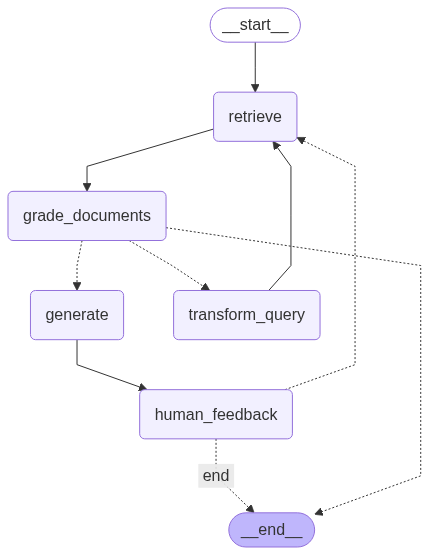

In [73]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

workflow = StateGraph(State)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generate
workflow.add_node("transform_query", transform_query)  # transform_query
workflow.add_node("human_feedback", human_feedback) #review the TC generated and ensure there was no missing inputs
# workflow.add_node("hallucination_checker", hallucination_checker)

# Define the edges
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate"
    }
)
workflow.add_edge("transform_query", "retrieve")
workflow.add_edge("generate", "human_feedback")
# workflow.add_conditional_edges(
#     "hallucination_checker",
#     decide_if_hallucinated,
#     {
#         "human_feedback": "human_feedback",
#         "generate": "generate",
#     }
# )
workflow.add_conditional_edges(
    "human_feedback", 
    decide_to_approve,
    {
        "retrieve": "retrieve",
        "end": END,
    }
)

# Compile/Build the graph
graph = workflow.compile(checkpointer = memory)

#Print the structure of the Graph
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

# Execute Test Case Generation

In [75]:
thread = {"configurable": {"thread_id": 1}} #used to store all the checkpoints into memory
logtime = datetime.datetime.now().strftime("%Y_%m_%d-%H_%M_%S")
folder_path = "outputs/" + logtime
if not os.path.exists(folder_path):
    # If it doesn't exist, create it
    os.makedirs(folder_path)
    print(f"Folder '{folder_path}' created successfully.")
else:
    print(f"Folder '{folder_path}' already exists.")
    
# test_case_subject = "Intra-operative Import Subpanel's Bead Detection Algorithm Failure and execution of all available pathways on the Object Detection Error Pop-up"
test_case_subject = "All features related to the 'Locate Markers Breadcrumb Step' and 'Point to Markers Subpanel'"

for output in graph.stream({"question": test_case_subject, "iter": 0}, config=thread, stream_mode="updates"):
    for key, value in output.items():
        print("***** Result from Agent: ",key)
        
        try:
            last_message = next(iter(output.values()))["messages"][-1]
            last_message.pretty_print()
        except:
            print("pass")

Folder 'outputs/2025_07_06-23_27_40' created successfully.
---RETRIEVE---
***** Result from Agent:  retrieve
pass
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
***** Result from Agent:  grade_documents
pass
---GENERATE---
***** Result from Agent:  generate
pass
---EVALUATING TEST CASE CONTENT FOR COMPLETENESS---
Human said the missing feedback is:  cancel registration
---RETRIEVE MISSING SPECS FROM DATABASE---
***** Result from Agent:  human_feedback
pass
---RETRIEVE---


NameError: name 'new_question' is not defined

# Conclusions from Experiments:

**Retrieval of documents from VectorStore:**

***Observation:*** We use the same embedding model to retrieve relevant documents/images from the database; Despite this, we are given different combos of doc chunks to evaluate each time that the retriever is invoked. (more precisely, we are given the same top 2 docs, but after the first 2, we get a whole bunch of different non-sense.)

***TODO:*** Look into how to make the retrieval of relevant documents more consistent. (Not a Strong Priority)
- Option 1: Add Human in the loop (to identify if any details are missing)***
- Option 2: Get the LLM to ask Clarifying Questions 
- Alternative: Change this into a manual input to the rest of the system.

---

**Relevancy Grader:**
- system1 prompt > system3 > system2 (from less stringent to most stringent)
- Using the "system1" prompt, Llama scored more of the SWRS as relevant > Gemma > Granite
- Next Steps: Make the Relevancy Grader less stringent 
    - make vectorstore retrieve all keywords from requirements that were graded as relevant (make the transform query method re-ping the vectorstore for reqs. containing the keywords from the relevant reqs. and set a max iteration to 3?)

----

**Generate Test Cases:** 
- See conclusions in "main_RAG.ipynb" for why we chose the Llama model as the best model for test case creation. 
- The Generated Test cases show that the LLM has a tendency to hallucinate quite a lot. To reduce Hallucinations, we can try some methods:
    - Chain of thought. 
    - Provide more context and increase the context window of the LLM 

---

**Evaluate Test Cases vs. Input Contextual Document Database:**
- Right now the generated test cases adhere to the retrieved Specs that are fed to it; however, there are some weaknesses to this system:
    1. many related specs involving convoluted navigation scenarios have context holes for the preconditions 
        - Possible Solutions:
            - Add Human in the Loop to edit the content of the test case (alternative is to just do this before uploading to CB)
            - Feed a separate node the last line of the preconditions steps, and get the node to fetch all content in the SWRS to figure out how to get from the launch page to that panel.
                
    2. Many steps are missing the in-between steps in order to get from one spec to verify to the next step to verify. For example, any situation where you need to go all the way to reg. valid, reject the registration, and return to perform XXXX action.
        - Possible Solutions:
            - Implement chain of thought: Add "Let's think step by step" to the prompt asking it to identify the SWRS that explain how the user navigates from one step to the next. 
            - Allow the Test cases to be generated such that there is one test case per swrs, so if a step is missing, it means that you are missing a SwRS. 
            - Add a Human in the Loop to retrieve more requrements related to a new query containing key terms for specs that might be missing to complete the execution steps considering all of the context contained in the entire specs document. (IMPLEMENTED)
        

If you want to get test cases to be generated for an entire section of the application, we need a way to be able to group SwRS together to feed to the generator (one set of inputs of SwRs per Generator) to Parallelize the generation of Test Cases to Optimize for time. 

Feed a list of SwRS, and track which SwRS, if any the AI_Agent has skipped writing a TC for:
- parse the list of inputed SWRS and compare it with the outputted TCs .md file. 

# TO EVALUATE:
- Check if the generator gives you both positive and negative test cases; scnearios to test: importing images and different modalities; 

# Adding Chain of Thought to Evaluate the appropriateness of the test case steps returned to the user. 

In [ ]:
tc_to_eval_path = "./outputs/2025_07_01-22_23_53/AIAgent_llama3.1-8b_1.md"

#Break up the Test cases into separate .md files


def eval_test_case():
    '''
    For each .md file:
        Execute the first step = Send the preconditions and action to the vector store to retrieve all similar content. The LLM will then infer from the retrieved docs what should be displayed on the screen. 
        Compare what the LLM spat out with the expected result in the .md file. 
            If it passes, then keep the context of the history of the chat and add the next step. Feed all of this information to the LLM so that it figures out what should be displayed on the screen.
            If it fails, then send both outputs to the human to evaluate what to keep and what to discard. 
        Compare what the LLM  spat out with the expected result in the .md file. 
    '''

    system = """Let's think step by step.

            """
    
    print("---Finished Evaluating Test Case---")
